In [2]:
from plotting import *

In [3]:
ave_MEM_0 = np.loadtxt('output/w_MEM_cor_0_mom2__ave.txt')
err_MEM_0 = np.loadtxt('output/w_MEM_cor_0_mom2__sem.txt')
dt_MEM_0 = np.loadtxt('output/w_MEM_cor_0_mom2__dt.txt')

In [4]:
ave_MEM_1 = np.loadtxt('output/w_MEM_cor_1_mom2__ave.txt')
err_MEM_1 = np.loadtxt('output/w_MEM_cor_1_mom2__sem.txt')
dt_MEM_1 = np.loadtxt('output/w_MEM_cor_1_mom2__dt.txt')

In [5]:
ave_EM = np.loadtxt('output/w_EM_mom2__ave.txt')
err_EM = np.loadtxt('output/w_EM_mom2__sem.txt')
dt_EM = np.loadtxt('output/w_EM_mom2__dt.txt')

In [6]:
vcomp = 1

In [17]:
help(formatAndSave)

Help on function formatAndSave in module plotting:

formatAndSave(fig, ax, lines, xlabel, ylabel, legends=None, title=None, fontsize=14, filename=None)
    formats the current figure, and save to file if filename is provided.



Text(0, 0.5, 'Relative error in $<v_y^2>$')

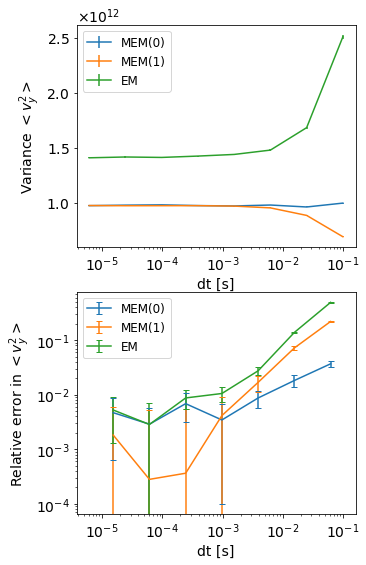

In [43]:
fig= plt.figure()
updateGlobal(14)
fig.set_size_inches(5, 9)
# plt.tight_layout()

ax1 = fig.add_subplot(211)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits=(0, 0), useMathText=True)

# fig, [ax1, ax2] = plt.subplots(2, 1)


for ave, err, lab in zip([ave_MEM_0, ave_MEM_1, ave_EM], 
                         [err_MEM_0, err_MEM_1, err_EM], 
                         ['MEM(0)', 'MEM(1)', 'EM']):
    ax1.errorbar(dt_EM, ave[:, vcomp], err[:, vcomp], label = lab)
    diff_ave = np.abs(np.diff(ave, axis = 0) / ave[1:, :])
#     ax2.plot(dt_EM[:-1], diff_ave[:, vcomp])
    t_mid = 0.5 * (dt_EM[:-1] + dt_EM[1:])
    ax2.errorbar(t_mid, diff_ave[:, vcomp], err[:-1, vcomp]/ ave[1:, vcomp], capsize = 3, label = lab)
    
for ax in [ax1, ax2]:    
    ax.set_xscale('log')
    ax.set_xlabel('dt [s]')
    ax.legend()

ax1.set_ylabel('Variance $<v_y^2>$')

ax2.set_yscale('log')
ax2.set_ylabel('Relative error in $<v_y^2>$')

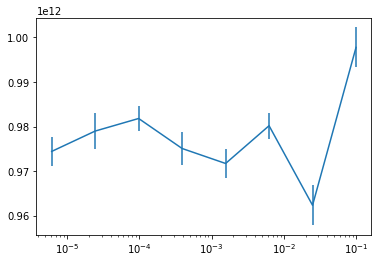

In [203]:
plt.errorbar(dt, ave_MEM_0[:, vcomp], err_MEM_0[:, vcomp])
plt.xscale('log')
# plt.yscale('log')

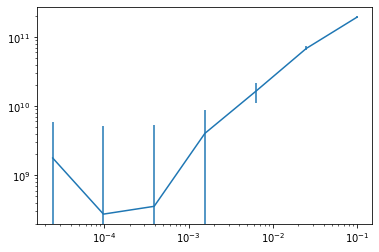

In [173]:
diff_ave = np.abs(np.diff(ave, axis = 0))
plt.errorbar(dt[:-1], diff_ave[:, vcomp], err[:-1, vcomp])
# plt.plot(dt[:-1], diff_ave[:, 0])
plt.yscale('log')
plt.xscale('log')